[*********************100%%**********************]  7 of 7 completed


Predicting for AAPL...


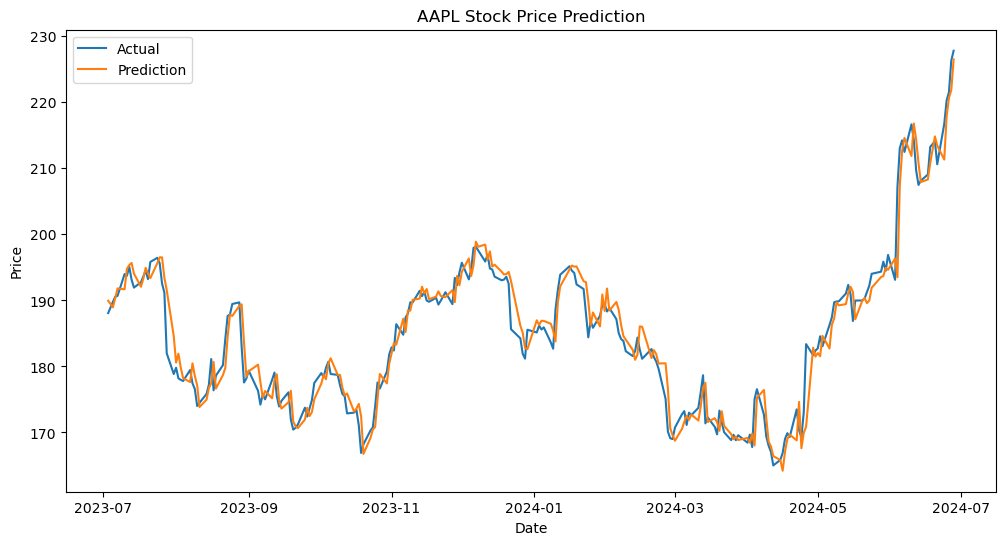

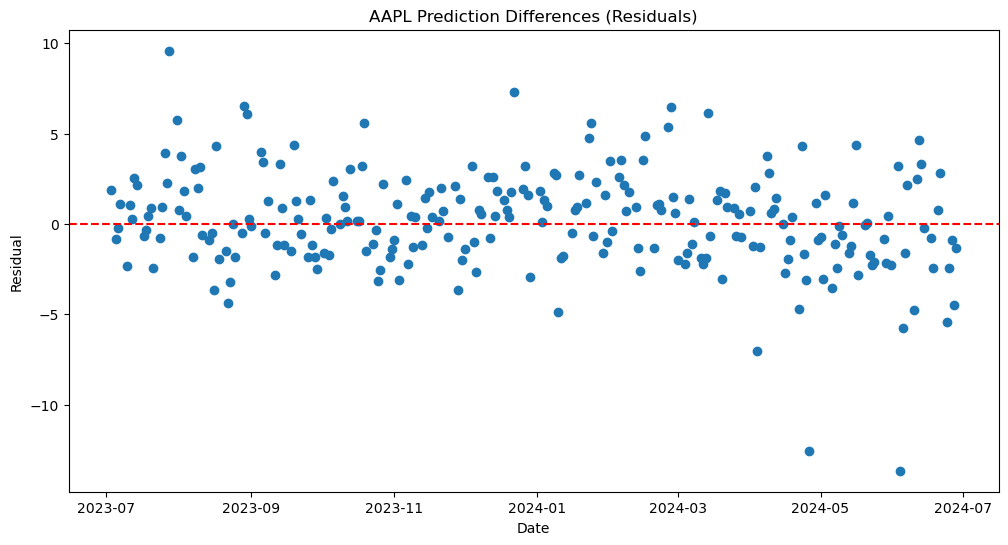

RMSE for AAPL: [43.42709833]

Predicting for MSFT...


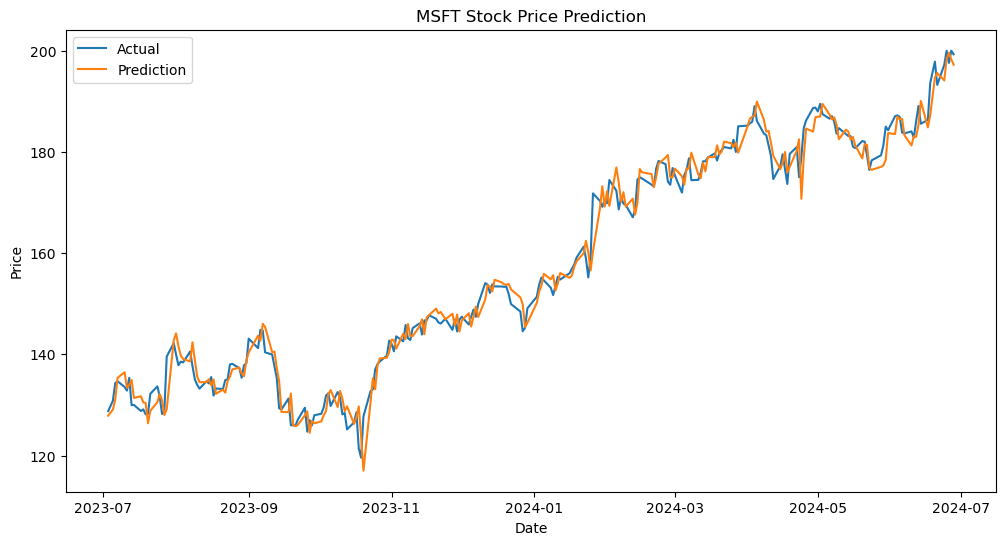

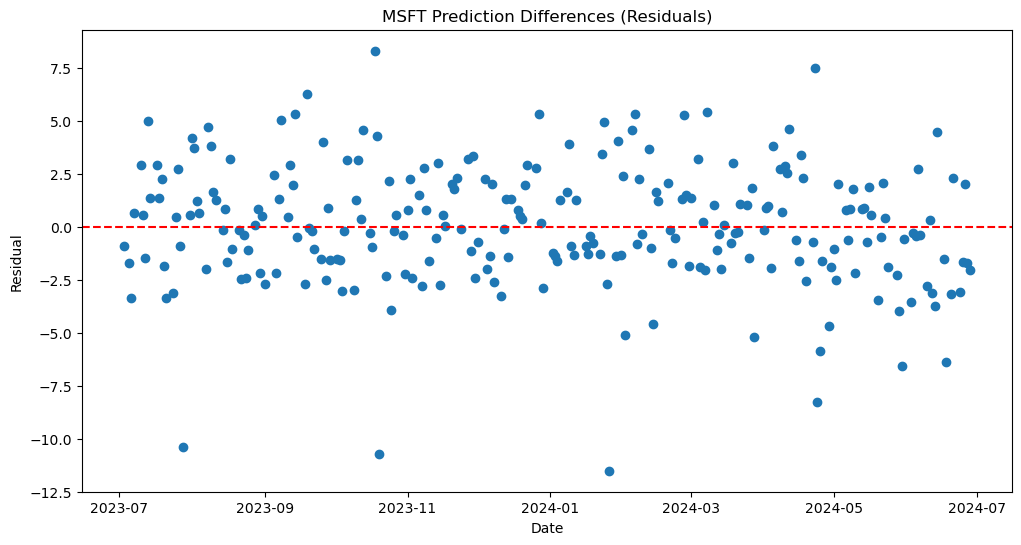

RMSE for MSFT: [44.90885707]

Predicting for AMZN...


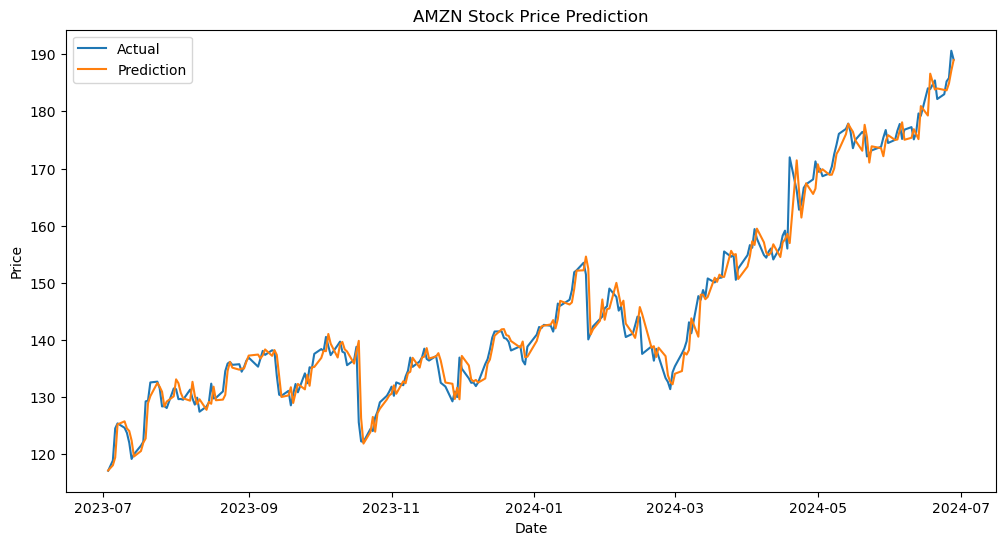

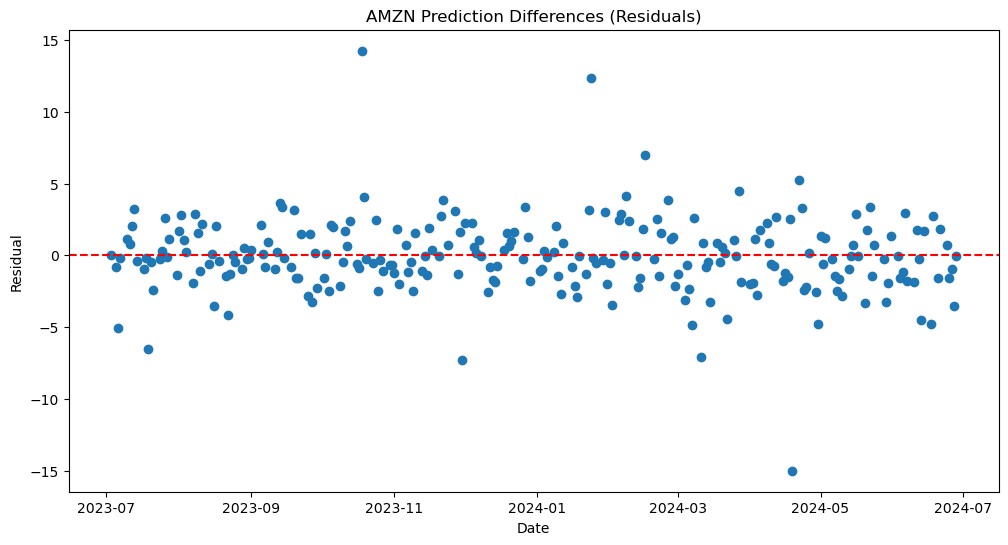

RMSE for AMZN: [41.35308294]

Predicting for GOOGL...


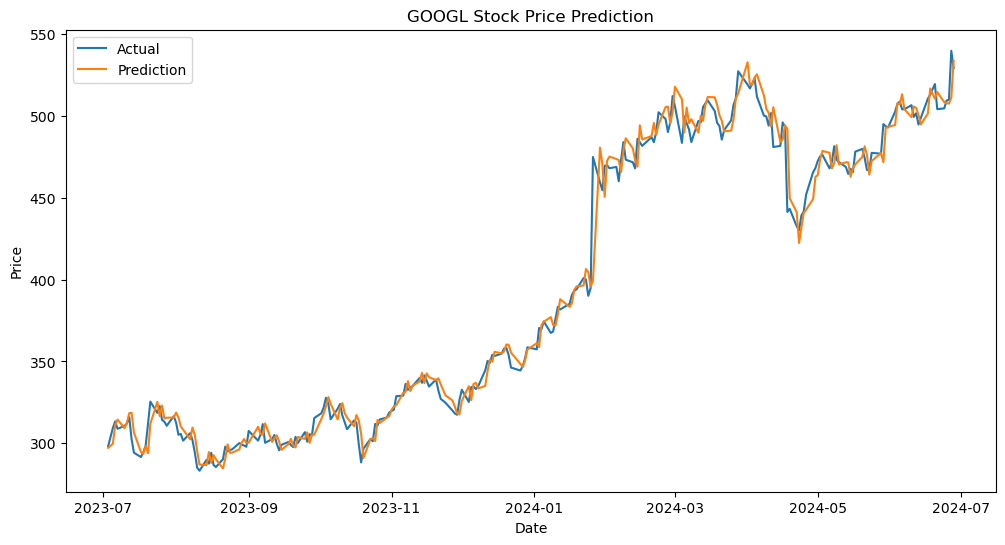

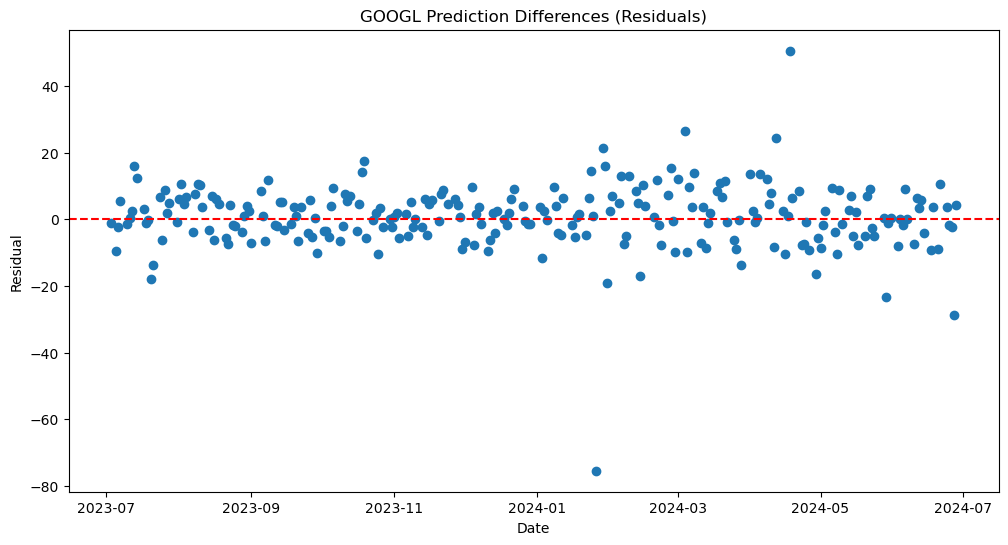

RMSE for GOOGL: [152.23834769]

Predicting for META...


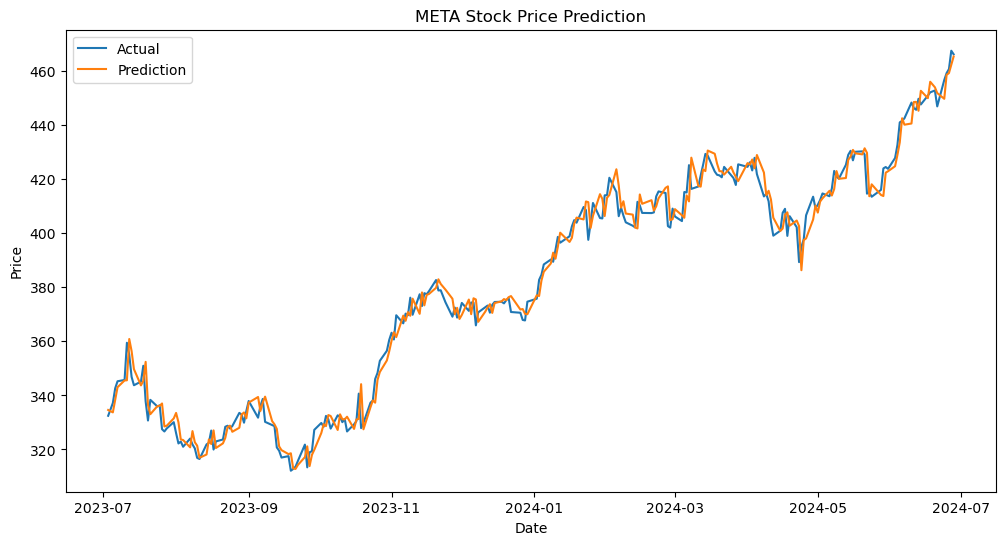

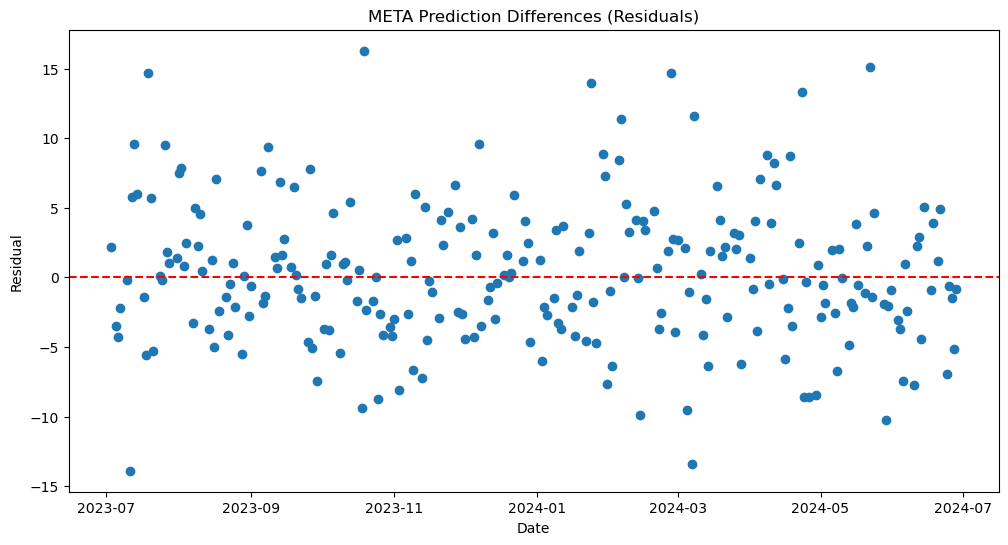

RMSE for META: [79.92346457]

Predicting for TSLA...


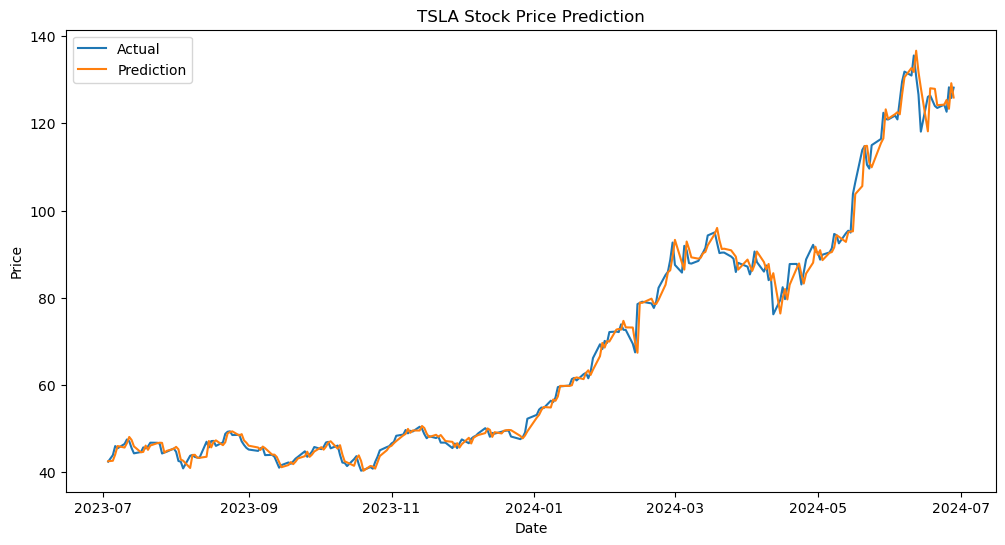

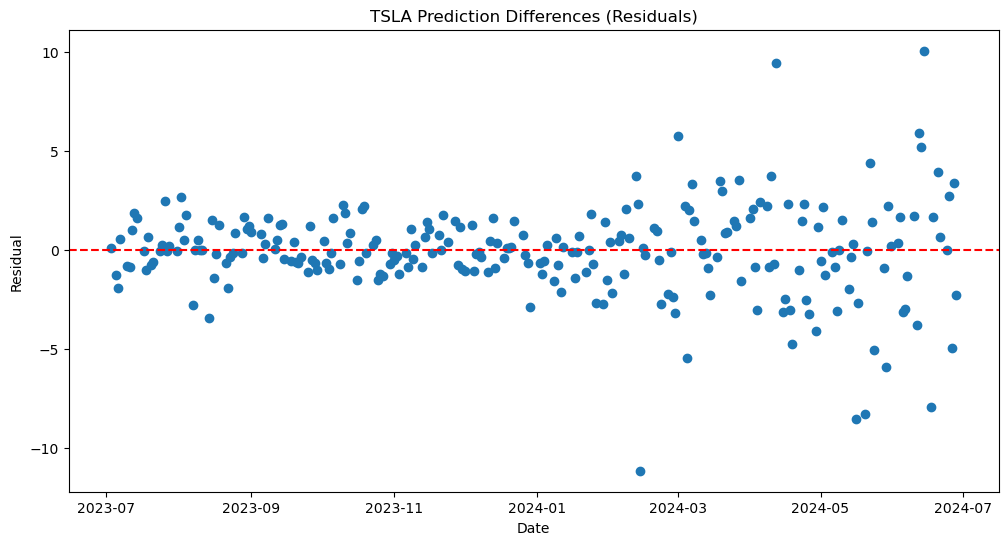

RMSE for TSLA: [36.4653915]

Predicting for NVDA...


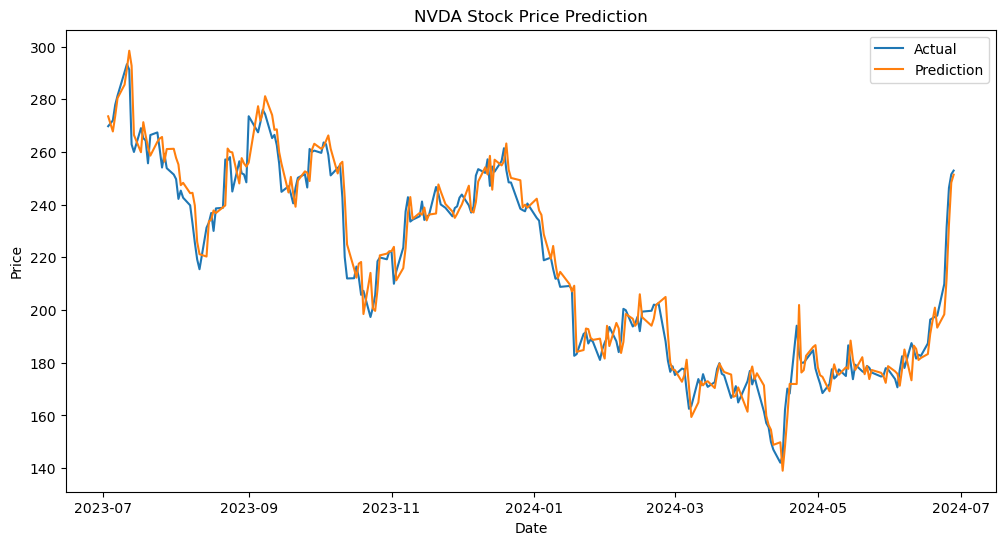

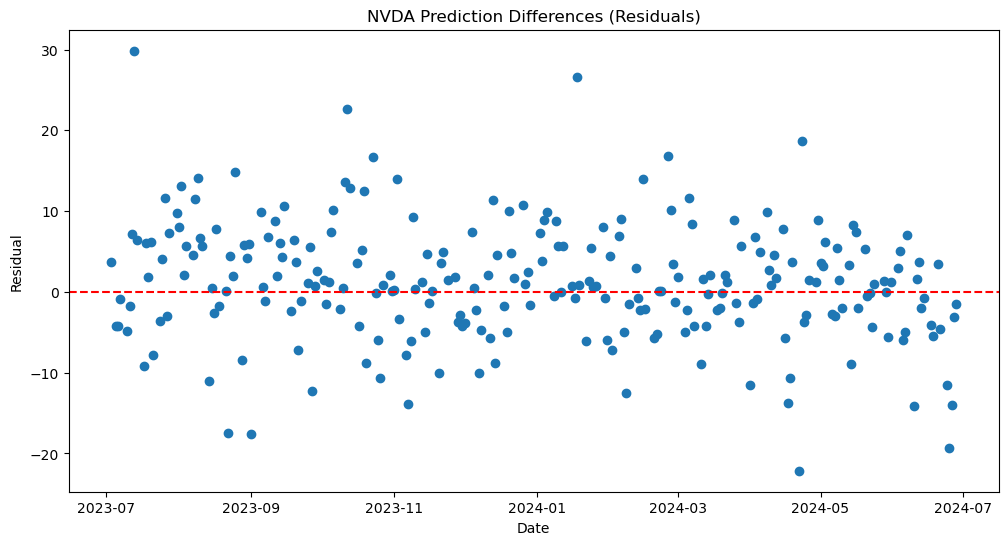

RMSE for NVDA: [116.77056561]



In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Download stock price data for the specified tickers from Yahoo Finance
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA"]
data = yf.download(tickers, start="2014-01-01", end=datetime.now().strftime("%Y-%m-%d"))["Close"]

# Rename columns for ease of use
data.columns = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA"]

# Function to create lagged features for a time series
def XDmat(ts, lags, max_lag=None):
    ts = ts.values
    if max_lag is None:
        max_lag = max(lags)
    else:
        if max_lag < max(lags):
            raise ValueError("max_lag < max(lags) in XDmat()")
    indMX = np.arange(len(ts) - max_lag)
    Xout = np.zeros((len(ts) - max_lag, len(lags)))
    for i, lag in enumerate(lags):
        Xout[:, i] = ts[indMX + max_lag - lag]
    return Xout

# Function to predict stock prices using linear regression
def F7predict(predict_stock, cov_stock, data=data, days_used=1000, days_predict=250):
    # Determine the maximum lag
    max_lag = max(max(lags) for lags in cov_stock.values() if lags)
    
    # Prepare the target variable (Y)
    Y = data[predict_stock].dropna()
    Y = XDmat(Y, [0], max_lag)
    
    # Prepare the predictor variables (X)
    X = np.hstack([XDmat(data[stock].dropna(), lags, max_lag) for stock, lags in cov_stock.items() if lags])
    
    # Number of available data points
    N_avail = len(X)
    
    # Indices for the prediction period
    days_predict_i = np.arange(N_avail - days_predict, N_avail)
    
    # Lists to store predictions and actual values
    current_est = []
    current_obs = []
    
    # Perform predictions
    for i in range(days_predict):
        X0 = X[days_predict_i[i] - days_used:days_predict_i[i]]
        Y0 = Y[days_predict_i[i] - days_used:days_predict_i[i]]
        model = LinearRegression(fit_intercept=False).fit(X0, Y0)
        current_est.append(model.predict([X[days_predict_i[i]]])[0])
        current_obs.append(Y[days_predict_i[i]])
    
    # Create a DataFrame for predictions and actual values
    pred_df = pd.DataFrame({
        "date": data.index[days_predict_i],
        "Prediction": current_est,
        "Actual": current_obs
    })
    
    # Melt the DataFrame for plotting
    pred_long = pd.melt(pred_df, id_vars=["date"], value_vars=["Prediction", "Actual"], var_name="Type", value_name="price")
    
    # Plot the predictions and actual values
    plt.figure(figsize=(12, 6))
    for label, df in pred_long.groupby("Type"):
        plt.plot(df["date"], df["price"], label=label)
    plt.title(f"{predict_stock} Stock Price Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
    
    # Scatter plot of the differences (residuals)
    pred_df['Difference'] = pred_df['Prediction'] - pred_df['Actual']
    
    plt.figure(figsize=(12, 6))
    plt.scatter(pred_df["date"], pred_df["Difference"])
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.title(f"{predict_stock} Prediction Differences (Residuals)")
    plt.show()
    
    # Calculate the root mean squared error (RMSE)
    rmse = np.sqrt(np.sum((pred_df["Prediction"] - pred_df["Actual"])**2))
    
    return {"plot_out": plt, "RMSE": rmse}

# Define stocks and lags for prediction
cov_stock = {
    "AAPL": [1, 2, 3, 4, 5],
    "MSFT": [1, 2, 3, 4, 5],
    "AMZN": [1, 2, 3, 4, 5],
    "GOOGL": [1, 2, 3, 4, 5],
    "META": [1, 2, 3, 4, 5],
    "TSLA": [1, 2, 3, 4, 5],
    "NVDA": [1, 2, 3, 4, 5]
}

# Predict and plot for each stock
for ticker in tickers:
    print(f"Predicting for {ticker}...")
    result = F7predict(predict_stock=ticker, cov_stock=cov_stock)
    print(f"RMSE for {ticker}: {result['RMSE']}\n")
